# Download Data:
You can download the dataset using the commands below  and see it’s description at https://www.openml.org/d/31

### Attribute description from https://www.openml.org/d/31

1. Status of existing checking account, in Deutsche Mark.
2. Duration in months
3. Credit history (credits taken, paid back duly, delays, critical accounts)
4. Purpose of the credit (car, television,...)
5. Credit amount
6. Status of savings account/bonds, in Deutsche Mark.
7. Present employment, in number of years.
8. Installment rate in percentage of disposable income
9. Personal status (married, single,...) and sex
10. Other debtors / guarantors
11. Present residence since X years
12. Property (e.g. real estate)
13. Age in years
14. Other installment plans (banks, stores)
15. Housing (rent, own,...)
16. Number of existing credits at this bank
17. Job
18. Number of people being liable to provide maintenance for
19. Telephone (yes,no)
20. Foreign worker (yes,no)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install scikit-learn feature_engine -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import feature_engine
import sklearn
import sys
from scipy.io import arff
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from feature_engine.encoding import RareLabelEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.transformation import LogTransformer
from scipy.stats import loguniform
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [ ]:
base = Path("/content/drive/MyDrive/Applied_ML/Class_4/Assignment")

In [ ]:
custom_function_folder = base/"Custom_function"

In [ ]:
sys.path.append(str(custom_function_folder))

In [ ]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Applied_ML/Class_4/Assignment/Custom_function']

In [ ]:
from eda_plots import diagnostic_plots, plot_target_by_category

In [ ]:
from  plot_learning_curve import plot_learning_curve

In [ ]:
A,b = fetch_openml("credit-g", version=1, as_frame=True, return_X_y=True)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
categorical_1 = [var for var in A.columns if A[var].dtype == "category"]
discrete_1 = [var for var in A.columns if A[var].dtype != "category" and (len(A[var].unique())< 20)]
continous_1 = [ var for var in A.columns if A[var].dtype != 'category'
              and var not in discrete_1]

In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin

class ConvertToNumpyArray(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self, X):
        return np.array(X)

In [ ]:
A_train,A_test,b_train,b_test= train_test_split(A,b,test_size=0.33,random_state=0)

In [ ]:
rare_labels_1 = ["foreign_worker","purpose"]
columns_to_transform_1 = ["age","credit_amount","duration"]

In [ ]:
EDA_credit = Pipeline([
    ('rare_label_encoder',RareLabelEncoder(n_categories=1,variables=rare_labels_1,ignore_format=True)),
    ('one_hot_encoder',OneHotEncoder(variables=categorical_1,ignore_format = True)),
    ('yj_transformer',YeoJohnsonTransformer(variables=columns_to_transform_1)),
    ('array_conversion',ConvertToNumpyArray())
])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
A_train_processed = EDA_credit.fit_transform(A_train)

In [ ]:
set_config(display="diagram")
EDA_credit

Pipeline(steps=[('rare_label_encoder',
                 RareLabelEncoder(ignore_format=True, n_categories=1,
                                  variables=['foreign_worker', 'purpose'])),
                ('one_hot_encoder',
                 OneHotEncoder(ignore_format=True,
                               variables=['checking_status', 'credit_history',
                                          'purpose', 'savings_status',
                                          'employment', 'personal_status',
                                          'other_parties', 'property_magnitude',
                                          'other_payment_plans', 'housing',
                                          'job', 'own_telephone',
                                          'foreign_worker'])),
                ('yj_transformer',
                 YeoJohnsonTransformer(variables=['age', 'credit_amount',
                                                  'duration'])),
                ('array_conversion', ConvertToNumpyArray())])

In [ ]:
train_scores = []
oog_scores = []
best_n_est = 50
best_oog_scores = 0

cgrf = RandomForestClassifier(random_state=0,warm_start=True,oob_score=True)
est = range(50,500,10)
for n in est:
  cgrf.n_estimators = n
  cgrf.fit(A_train_processed,b_train)
  train_scores.append(cgrf.score(A_train_processed,b_train))
  oog_scores.append(cgrf.oob_score_)
  if cgrf.oob_score_ > best_oog_scores:
    best_n_est = n
    best_oog_scores = cgrf.oob_score_

In [ ]:
print(best_n_est)

420


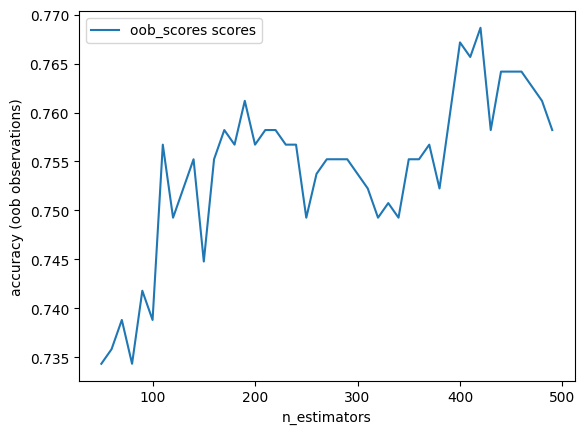

In [ ]:
plt.plot(est, oog_scores, label="oob_scores scores")
plt.ylabel("accuracy (oob observations)")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

In [ ]:
rf_pipeline = Pipeline([
    ('rare_label_encoder',RareLabelEncoder(n_categories=1,variables=rare_labels_1,ignore_format=True)),
    ('one_hot_encoder',OneHotEncoder(variables=categorical_1,ignore_format = True)),
    ('yj_transformer',YeoJohnsonTransformer(variables=columns_to_transform_1)),
    ('array_conversion',ConvertToNumpyArray()),
    ('rf_pipeline',RandomForestClassifier(random_state=0,oob_score=True))
])

In [ ]:
grid = {
    "rf_pipeline__n_estimators" :[240],
    "rf_pipeline__max_features" :["sqrt","log2"],
    'rf_pipeline__max_depth': np.arange(2,10),
    'rf_pipeline__min_samples_leaf': np.arange(2,20),
    'rf_pipeline__max_leaf_nodes': np.arange(2, 20),
    'rf_pipeline__min_impurity_decrease': loguniform(0.00001, 0.1),
}

In [ ]:
grid_rf = HalvingRandomSearchCV(rf_pipeline, grid, cv=5, return_train_score=True, n_jobs=-1)

In [ ]:
grid_rf.fit(A_train,b_train)

HalvingRandomSearchCV(estimator=Pipeline(steps=[('rare_label_encoder',
                                                 RareLabelEncoder(ignore_format=True,
                                                                  n_categories=1,
                                                                  variables=['foreign_worker',
                                                                             'purpose'])),
                                                ('one_hot_encoder',
                                                 OneHotEncoder(ignore_format=True,
                                                               variables=['checking_status',
                                                                          'credit_history',
                                                                          'purpose',
                                                                          'savings_status',
                                                                          'employment',
                                                                          'personal_status',
                                                                          'other_parties',
                                                                          'property_magnit...
                                           'rf_pipeline__max_features': ['sqrt',
                                                                         'log2'],
                                           'rf_pipeline__max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                           'rf_pipeline__min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ceab4287ee0>,
                                           'rf_pipeline__min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                           'rf_pipeline__n_estimators': [240]})

In [ ]:
grid_rf.best_params_

{'rf_pipeline__max_depth': 4,
 'rf_pipeline__max_features': 'log2',
 'rf_pipeline__max_leaf_nodes': 5,
 'rf_pipeline__min_impurity_decrease': 0.00014450567696695256,
 'rf_pipeline__min_samples_leaf': 10,
 'rf_pipeline__n_estimators': 240}

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

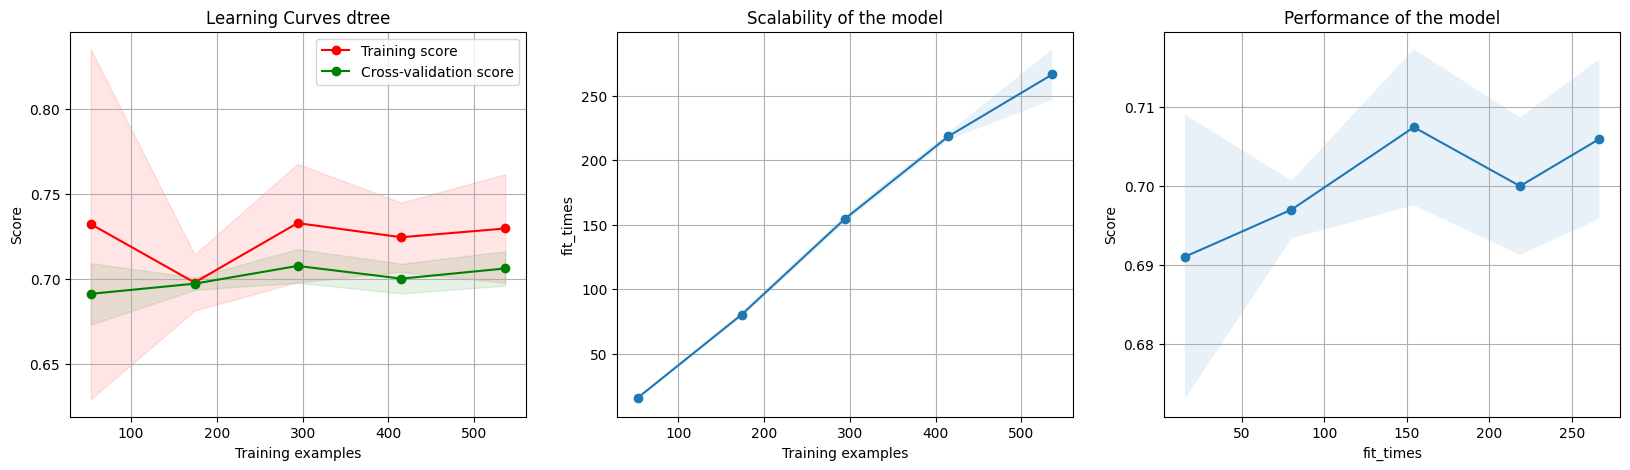

In [ ]:
plot_learning_curve(grid_rf,
                    'Learning Curves dtree',
                    A_train, b_train, n_jobs=-1)

In [ ]:
grid_rf.best_score_

0.7

In [ ]:
grid_2 = {
    "rf_pipeline__max_features":["log2"],
    "rf_pipeline__n_estimators":[240],
    "rf_pipeline__max_depth":np.arange(8,19,2),
    "rf_pipeline__min_samples_leaf":np.arange(3,8,1),
    "rf_pipeline__max_leaf_nodes": np.arange(8,19,2),
}

In [ ]:
grid_rf_2 = HalvingRandomSearchCV(rf_pipeline, grid_2, cv=5, return_train_score=True, n_jobs=-1)

In [ ]:
grid_rf_2.fit(A_train,b_train)

HalvingRandomSearchCV(estimator=Pipeline(steps=[('rare_label_encoder',
                                                 RareLabelEncoder(ignore_format=True,
                                                                  n_categories=1,
                                                                  variables=['foreign_worker',
                                                                             'purpose'])),
                                                ('one_hot_encoder',
                                                 OneHotEncoder(ignore_format=True,
                                                               variables=['checking_status',
                                                                          'credit_history',
                                                                          'purpose',
                                                                          'savings_status',
                                                                          'employment',
                                                                          'personal_status',
                                                                          'other_parties',
                                                                          'property_magnit...
                                                 ConvertToNumpyArray()),
                                                ('rf_pipeline',
                                                 RandomForestClassifier(oob_score=True,
                                                                        random_state=0))]),
                      n_jobs=-1,
                      param_distributions={'rf_pipeline__max_depth': array([ 8, 10, 12, 14, 16, 18]),
                                           'rf_pipeline__max_features': ['log2'],
                                           'rf_pipeline__max_leaf_nodes': array([ 8, 10, 12, 14, 16, 18]),
                                           'rf_pipeline__min_samples_leaf': array([3, 4, 5, 6, 7]),
                                           'rf_pipeline__n_estimators': [240]})

In [ ]:
grid_rf_2.best_params_

{'rf_pipeline__n_estimators': 240,
 'rf_pipeline__min_samples_leaf': 5,
 'rf_pipeline__max_leaf_nodes': 10,
 'rf_pipeline__max_features': 'log2',
 'rf_pipeline__max_depth': 10}

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

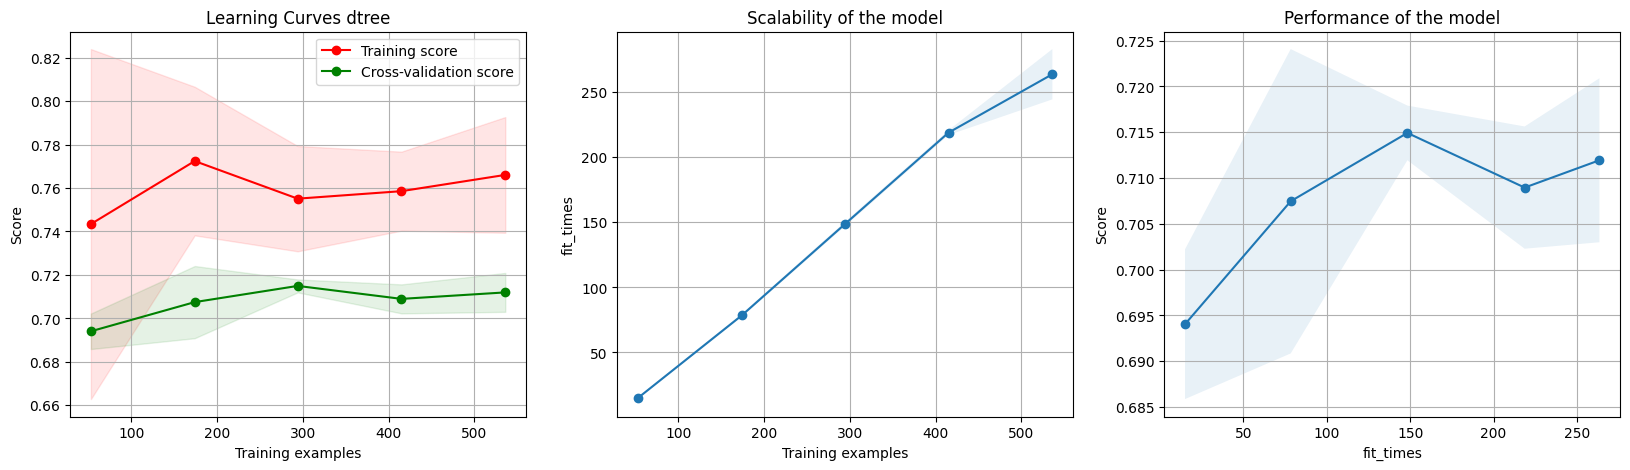

In [ ]:
plot_learning_curve(grid_rf_2,
                    'Learning Curves dtree',
                    A_train, b_train, n_jobs=-1)

In [ ]:
grid_rf_2.best_score_

0.725925925925926

In [ ]:
grid_3 = {
     "rf_pipeline__max_features":["log2"],
    "rf_pipeline__n_estimators":np.arange(200,400,20),
    "rf_pipeline__max_depth":[10],
    "rf_pipeline__min_samples_leaf":[5],
    "rf_pipeline__max_leaf_nodes": [10],
}


In [ ]:
grid_rf_3 = HalvingGridSearchCV(rf_pipeline, grid_3, cv=5, return_train_score=True, n_jobs=-1)

In [ ]:
grid_rf_3.fit(A_train,b_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('rare_label_encoder',
                                               RareLabelEncoder(ignore_format=True,
                                                                n_categories=1,
                                                                variables=['foreign_worker',
                                                                           'purpose'])),
                                              ('one_hot_encoder',
                                               OneHotEncoder(ignore_format=True,
                                                             variables=['checking_status',
                                                                        'credit_history',
                                                                        'purpose',
                                                                        'savings_status',
                                                                        'employment',
                                                                        'personal_status',
                                                                        'other_parties',
                                                                        'property_magnitud...
                                              ('array_conversion',
                                               ConvertToNumpyArray()),
                                              ('rf_pipeline',
                                               RandomForestClassifier(oob_score=True,
                                                                      random_state=0))]),
                    n_jobs=-1,
                    param_grid={'rf_pipeline__max_depth': [10],
                                'rf_pipeline__max_features': ['log2'],
                                'rf_pipeline__max_leaf_nodes': [10],
                                'rf_pipeline__min_samples_leaf': [5],
                                'rf_pipeline__n_estimators': array([200, 220, 240, 260, 280, 300, 320, 340, 360, 380])})

In [ ]:
grid_rf_3.best_params_

{'rf_pipeline__max_depth': 10,
 'rf_pipeline__max_features': 'log2',
 'rf_pipeline__max_leaf_nodes': 10,
 'rf_pipeline__min_samples_leaf': 5,
 'rf_pipeline__n_estimators': 360}

In [ ]:
grid_rf_3.best_score_

0.7097744360902256

I would Consider grid 2 as my better model. But i would prefer KNN for the dataset as i am getting validation score of 80 there
